In [101]:
tf.compat.v1.reset_default_graph()

In [102]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow import keras

In [103]:
# Lee el csv con el dataset
df = pd.read_csv('./butterflies and moths.csv')
df

,class id,filepaths,labels,data set
0,0,train/ADONIS/001.jpg,ADONIS,train
1,0,train/ADONIS/002.jpg,ADONIS,train
2,0,train/ADONIS/003.jpg,ADONIS,train
3,0,train/ADONIS/004.jpg,ADONIS,train
4,0,train/ADONIS/005.jpg,ADONIS,train
...,...,...,...,...
13589,99,valid/ZEBRA LONG WING/1.jpg,ZEBRA LONG WING,valid
13590,99,valid/ZEBRA LONG WING/2.jpg,ZEBRA LONG WING,valid
13591,99,valid/ZEBRA LONG WING/3.jpg,ZEBRA LONG WING,valid
13592,99,valid/ZEBRA LONG WING/4.jpg,ZEBRA LONG WING,valid


In [104]:
# Saca el total de especies disintas
df['labels'].nunique()

100

In [105]:
# Muestra la cantidad de datos para train, valid y test
df['data set'].value_counts()

data set
train    12594
test       500
valid      500
Name: count, dtype: int64

In [106]:
# Muestra la cantidad de datos por mariposa de los train
df[df['data set'] == 'train']['labels'].value_counts()

labels
MOURNING CLOAK         187
GREEN HAIRSTREAK       176
BROWN ARGUS            169
BROOKES BIRDWING       165
SLEEPY ORANGE          152
                      ... 
GOLD BANDED            104
CRIMSON PATCH          103
MALACHITE              103
WOOD SATYR             102
SIXSPOT BURNET MOTH    100
Name: count, Length: 100, dtype: int64

In [107]:
# Muestra la cantidad mínima y máxima de imágenes para una especie para los datos de prueba
df[df['data set'] == 'test']['labels'].value_counts().min(), df[df['data set'] == 'test']['labels'].value_counts().max()

(np.int64(5), np.int64(5))

In [108]:
# Muestra la cantidad mínima y máxima de imágenes para una especie para los datos de validación
df[df['data set'] == 'valid']['labels'].value_counts().min(), df[df['data set'] == 'valid']['labels'].value_counts().max()

(np.int64(5), np.int64(5))

Podemos ver que, como mínimo, tenemos 100 imágenes por especie, llegando a las 187 como máximo en el conjunto de entrenamiento.

Por otro lado, para los datos de prueba y validación hay 5 por especie.

In [109]:
# Saca el diccionario con la clase de la especie y su nombre
dict_name = dict(zip( df['class id'], df['labels']))
dict_name

{0: 'ADONIS',
 1: 'AFRICAN GIANT SWALLOWTAIL',
 2: 'AMERICAN SNOOT',
 3: 'AN 88',
 4: 'APPOLLO',
 5: 'ARCIGERA FLOWER MOTH',
 6: 'ATALA',
 7: 'ATLAS MOTH',
 8: 'BANDED ORANGE HELICONIAN',
 9: 'BANDED PEACOCK',
 10: 'BANDED TIGER MOTH',
 11: 'BECKERS WHITE',
 12: 'BIRD CHERRY ERMINE MOTH',
 13: 'BLACK HAIRSTREAK',
 14: 'BLUE MORPHO',
 15: 'BLUE SPOTTED CROW',
 16: 'BROOKES BIRDWING',
 17: 'BROWN ARGUS',
 18: 'BROWN SIPROETA',
 19: 'CABBAGE WHITE',
 20: 'CAIRNS BIRDWING',
 21: 'CHALK HILL BLUE',
 22: 'CHECQUERED SKIPPER',
 23: 'CHESTNUT',
 24: 'CINNABAR MOTH',
 25: 'CLEARWING MOTH',
 26: 'CLEOPATRA',
 27: 'CLODIUS PARNASSIAN',
 28: 'CLOUDED SULPHUR',
 29: 'COMET MOTH',
 30: 'COMMON BANDED AWL',
 31: 'COMMON WOOD-NYMPH',
 32: 'COPPER TAIL',
 33: 'CRECENT',
 34: 'CRIMSON PATCH',
 35: 'DANAID EGGFLY',
 36: 'EASTERN COMA',
 37: 'EASTERN DAPPLE WHITE',
 38: 'EASTERN PINE ELFIN',
 39: 'ELBOWED PIERROT',
 40: 'EMPEROR GUM MOTH',
 41: 'GARDEN TIGER MOTH',
 42: 'GIANT LEOPARD MOTH',
 43: 'GLITTER

In [110]:
# Descarga todas las imágenes en el dataframe en una nueva columna llamada image en forma de array
# df['image'] = df['filepaths'].apply(lambda x: img_to_array(load_img(x, target_size=(224, 224))) / 127.5 - 1)

In [111]:
df['image'] = df['filepaths'].apply(lambda x: img_to_array(load_img(x, target_size=(224, 224))) / 255)

In [112]:
df.head()

,class id,filepaths,labels,data set,image
0,0,train/ADONIS/001.jpg,ADONIS,train,"[[[0.0, 0.02745098, 0.003921569], [0.0, 0.0549..."
1,0,train/ADONIS/002.jpg,ADONIS,train,"[[[0.33333334, 0.29803923, 0.12941177], [0.313..."
2,0,train/ADONIS/003.jpg,ADONIS,train,"[[[0.50980395, 0.48235294, 0.3019608], [0.5098..."
3,0,train/ADONIS/004.jpg,ADONIS,train,"[[[0.54509807, 0.5254902, 0.29803923], [0.5450..."
4,0,train/ADONIS/005.jpg,ADONIS,train,"[[[0.61960787, 0.654902, 0.2901961], [0.619607..."


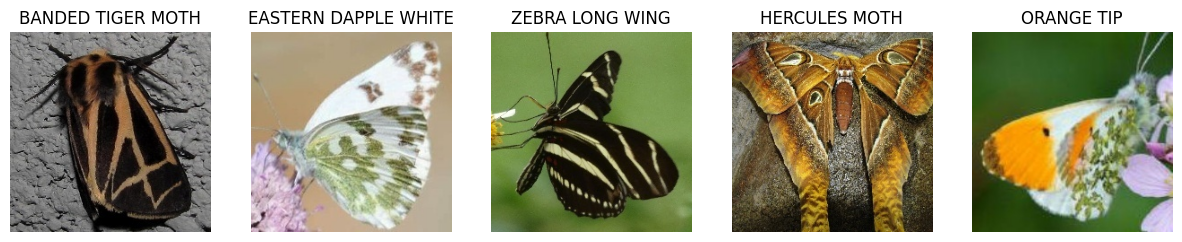

In [113]:
# Muestra 5 imágenes aleatorias de prueba
df_sample = df[['image', 'labels']].sample(5)
plt.figure(figsize=(15, 15))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(df_sample.iloc[i, 0])
    plt.title(df_sample.iloc[i, 1])
    plt.axis('off')
plt.show()

In [114]:
# Separa en datos de entrenamiento, validación y prueba
train_df = df[df['data set'] == 'train'][['class id', 'image']]
valid_df = df[df['data set'] == 'valid'][['class id', 'image']]
test_df = df[df['data set'] == 'test'][['class id', 'image']]

In [115]:
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df

,class id,image
0,7,"[[[0.2901961, 0.37254903, 0.44705883], [0.3058..."
1,24,"[[[0.36862746, 0.50980395, 0.4], [0.3882353, 0..."
2,61,"[[[0.3882353, 0.3137255, 0.25490198], [0.34901..."
3,41,"[[[0.5568628, 0.3764706, 0.28627452], [0.52941..."
4,99,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,..."
...,...,...
12589,52,"[[[0.8980392, 0.8352941, 0.7058824], [0.901960..."
12590,69,"[[[0.6, 0.68235296, 0.2784314], [0.627451, 0.7..."
12591,15,"[[[0.8627451, 0.85490197, 0.77254903], [0.8352..."
12592,94,"[[[0.34509805, 0.5058824, 0.5294118], [0.43137..."


In [116]:
valid_df = valid_df.sample(frac=1).reset_index(drop=True)
valid_df

,class id,image
0,77,"[[[0.6745098, 0.78431374, 0.79607844], [0.6117..."
1,5,"[[[0.99607843, 0.99607843, 0.99607843], [0.996..."
2,13,"[[[0.39215687, 0.33333334, 0.078431375], [0.38..."
3,97,"[[[0.011764706, 0.039215688, 0.007843138], [0...."
4,72,"[[[0.9411765, 0.9137255, 0.9843137], [0.949019..."
...,...,...
495,48,"[[[0.6784314, 0.4509804, 0.2627451], [0.674509..."
496,24,"[[[0.50980395, 0.63529414, 0.38039216], [0.560..."
497,24,"[[[0.45490196, 0.5647059, 0.12156863], [0.4549..."
498,89,"[[[0.38431373, 0.6117647, 0.2784314], [0.38431..."


In [117]:
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df

,class id,image
0,21,"[[[0.19607843, 0.24313726, 0.09411765], [0.207..."
1,49,"[[[0.5019608, 0.65882355, 0.41568628], [0.4901..."
2,9,"[[[0.3647059, 0.24705882, 0.105882354], [0.419..."
3,43,"[[[0.08627451, 0.21568628, 0.0], [0.11372549, ..."
4,74,"[[[0.08627451, 0.11764706, 0.0], [0.09019608, ..."
...,...,...
495,33,"[[[0.23137255, 0.36078432, 0.09019608], [0.227..."
496,40,"[[[0.043137256, 0.18039216, 0.25490198], [0.04..."
497,59,"[[[0.18431373, 0.19215687, 0.13725491], [0.2, ..."
498,13,"[[[0.4745098, 0.61960787, 0.25490198], [0.4784..."


In [118]:
X_train, y_train = train_df['image'], train_df['class id']

In [119]:
X_train

0        [[[0.2901961, 0.37254903, 0.44705883], [0.3058...
1        [[[0.36862746, 0.50980395, 0.4], [0.3882353, 0...
2        [[[0.3882353, 0.3137255, 0.25490198], [0.34901...
3        [[[0.5568628, 0.3764706, 0.28627452], [0.52941...
4        [[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...
                               ...                        
12589    [[[0.8980392, 0.8352941, 0.7058824], [0.901960...
12590    [[[0.6, 0.68235296, 0.2784314], [0.627451, 0.7...
12591    [[[0.8627451, 0.85490197, 0.77254903], [0.8352...
12592    [[[0.34509805, 0.5058824, 0.5294118], [0.43137...
12593    [[[0.6392157, 0.42352942, 0.34117648], [0.6509...
Name: image, Length: 12594, dtype: object

In [120]:
y_train

0         7
1        24
2        61
3        41
4        99
         ..
12589    52
12590    69
12591    15
12592    94
12593    45
Name: class id, Length: 12594, dtype: int64

In [121]:
X_valid, y_valid = valid_df['image'], valid_df['class id']

In [122]:
X_test, y_test = test_df['image'], test_df['class id']

In [123]:
num_classes = y_train.nunique()

In [124]:
# Convierte las etiquetas en one-hot
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [125]:
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=num_classes)
y_valid

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [126]:
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [127]:
# Define el modelo con L2 Regularization y Dropout optimizado
model = keras.Sequential([
    # Tamaño de entrada
    Input((224, 224, 3)),
    # Primera capa convolucional
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D(2, 2),
    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D(2, 2),
    # Tercera capa convolucional
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D(2, 2),
    Dropout(0.3),  # Dropout en la tercera capa
    # Cuarta capa convolucional
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D(2, 2),
    Dropout(0.4),  # Dropout más alto en la última capa convolucional
    # Pasa de dos dimensiones a una
    Flatten(),
    # Capa densa con regularización
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    # Capa de salida
    Dense(100, activation='softmax')  # 100 clases de mariposas
])

# Compilar el modelo
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar resumen del modelo
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        51,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,314,596 (73.68 MB)

 Trainable params: 19,314,596 (73.68 MB)

 Non-trainable params: 0 (0.00 B)

In [128]:
# Comprobamos el tipo
X_train.dtype, y_train.dtype, X_valid.dtype, y_valid.dtype, X_test.dtype, y_test.dtype

(dtype('O'),
 dtype('float64'),
 dtype('O'),
 dtype('float64'),
 dtype('O'),
 dtype('float64'))

In [129]:
# Cambiamos los conjuntos X a tipo flotante
X_train = np.array(X_train.tolist())
X_valid = np.array(X_valid.tolist())
X_test = np.array(X_test.tolist())

In [130]:
# Comprobamos el tipo
X_train.dtype, y_train.dtype, X_valid.dtype, y_valid.dtype, X_test.dtype, y_test.dtype

(dtype('float32'),
 dtype('float64'),
 dtype('float32'),
 dtype('float64'),
 dtype('float32'),
 dtype('float64'))

In [131]:
# Callbacks para mejorar el entrenamiento
early_stopping = EarlyStopping(
    monitor='val_loss',  # Observa la pérdida en validación
    patience=5,  # Número de épocas sin mejora antes de detener
    restore_best_weights=True  # Recupera los mejores pesos
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Observa la pérdida en validación
    factor=0.5,  # Reduce el LR a la mitad
    patience=3,  # Reduce si no hay mejora en 3 épocas
    min_lr=1e-6  # Límite inferior para el LR
)

# Entrena el modelo con las mejoras
history = model.fit(
    X_train, y_train,
    epochs=50,  # Mayor número de épocas con EarlyStopping
    batch_size=64,  # Incremento en el batch size
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, reduce_lr]  # Agregamos callbacks
)


Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 174s 822ms/step - accuracy: 0.0232 - loss: 5.0803 - val_accuracy: 0.1920 - val_loss: 3.6851 - learning_rate: 0.0010
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 157s 795ms/step - accuracy: 0.1606 - loss: 3.7272 - val_accuracy: 0.4100 - val_loss: 2.8099 - learning_rate: 0.0010
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 155s 787ms/step - accuracy: 0.2723 - loss: 3.2108 - val_accuracy: 0.4800 - val_loss: 2.5055 - learning_rate: 0.0010
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 156s 789ms/step - accuracy: 0.3794 - loss: 2.8081 - val_accuracy: 0.5560 - val_loss: 2.2571 - learning_rate: 0.0010
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 156s 793ms/step - accuracy: 0.4357 - loss: 2.5695 - val_accuracy: 0.6140 - val_loss: 2.0084 - learning_rate: 0.0010
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 158s 799ms/step - accuracy: 0.4878 - loss: 2.4001 - val_accuracy: 0.6540 - val_loss: 1.9056 - learning_rate: 0.0010
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 155s 784ms/step - accura

In [ ]:
# Guardar el modelo entrenado
model.save('clasificador_mariposas_3.keras')

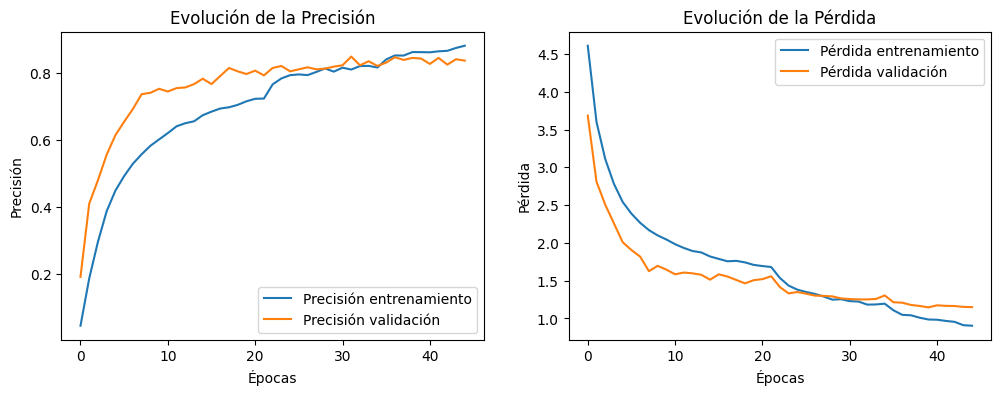

In [133]:
# Graficar la evolución del entrenamiento
plt.figure(figsize=(12, 4))

# Gráfico de precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Evolución de la Precisión')

# Gráfico de pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Evolución de la Pérdida')

plt.show()

In [134]:
test_loss, test_acc = model.evaluate(X_test, y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.8518 - loss: 1.0367


In [135]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)  # Convertir probabilidades a clases
true_classes = np.argmax(y_test, axis=1)  # Obtener etiquetas reales

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step


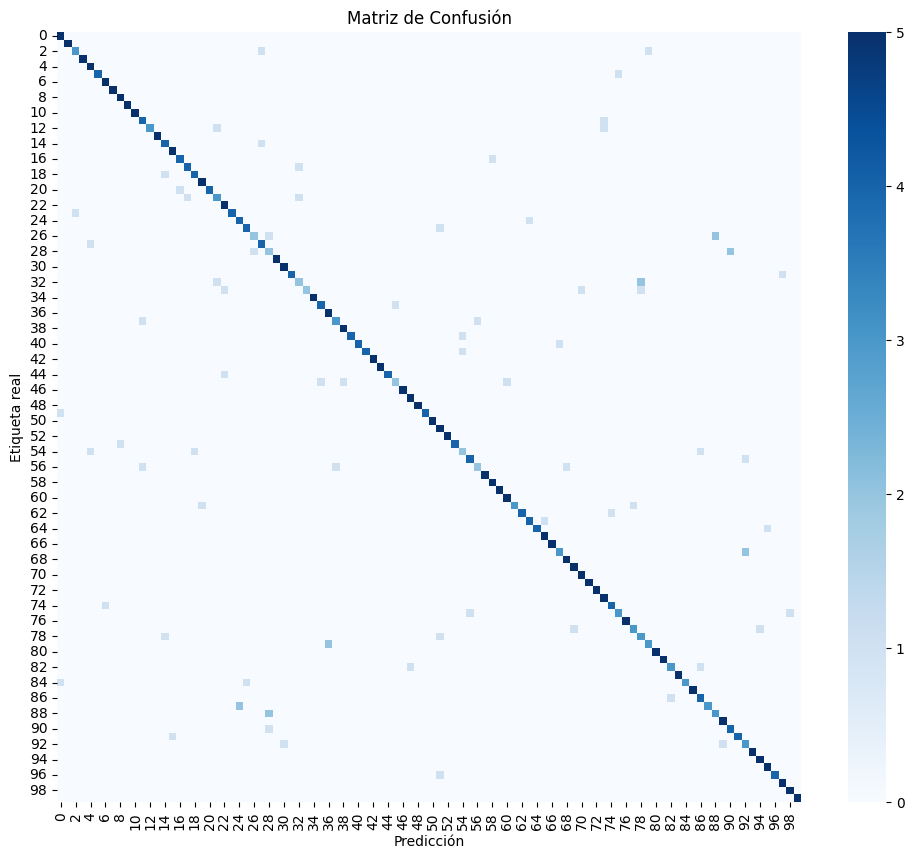

In [138]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', fmt='d')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.title('Matriz de Confusión')
plt.show()


In [ ]:
# Recoge el total de aciertos y fallos predichos
correct = np.sum(predicted_classes == true_classes)
incorrect = len(true_classes) - correct
correct, incorrect

(np.int64(421), np.int64(79))